<a href="https://colab.research.google.com/github/Akshai-Athota/DeepLearning/blob/main/NoisyStudentReplica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
device = "cuda" if torch.cuda.is_available()  else "cpu"
device

'cuda'

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [5]:
train_data = datasets.CIFAR10("./data",train=True,download=True,transform=transform)
test_data = datasets.CIFAR10("./data",train=False,download=True,transform=transform)

print(f"train data length : {len(train_data)}")
print(f"test data length : {len(test_data)}")

train data length : 50000
test data length : 10000


In [6]:
from torch.utils.data import Subset,random_split

small_train_data = Subset(train_data,range(10000))
print(f"small train data length : {len(small_train_data)}")

small train data length : 10000


In [7]:
labeled_data_samples = 5000
unlabeled_data_samples = len(small_train_data) - labeled_data_samples

labeled_data,unlabeled_data = random_split(small_train_data,
 [labeled_data_samples,unlabeled_data_samples],
 generator=torch.Generator().manual_seed(seed))

print(f"labeled data lenth : {len(labeled_data)}")
print(f"unlabeled data lenth : {len(unlabeled_data)}")

labeled data lenth : 5000
unlabeled data lenth : 5000


In [8]:
batch_size = 64
labeled_data_loader = DataLoader(labeled_data,shuffle=True,batch_size=64)
unlabeled_data_loader = DataLoader(unlabeled_data,shuffle=True,batch_size=64)
test_data_loader = DataLoader(test_data,batch_size=6)

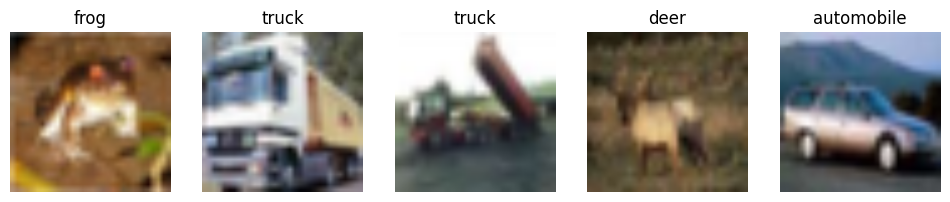

In [9]:
classes = train_data.classes

def show_samples(dataset,n=5):
  plt.figure(figsize=(12,3))
  for i in range(n):
    img,label = dataset[i]
    img = img * 0.5 + 0.5  # denormalize for display
    img = np.transpose(img, (1, 2, 0))
    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.title(classes[label])
    plt.axis('off')
  plt.show()

show_samples(train_data)

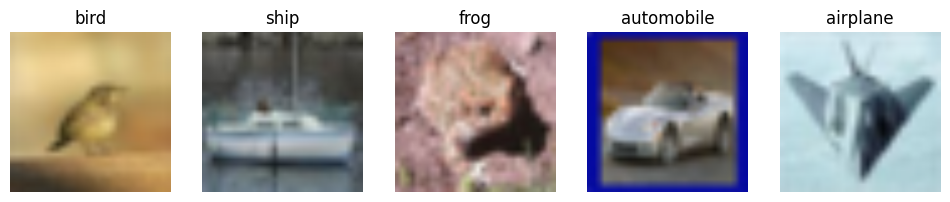

In [10]:
show_samples(labeled_data)

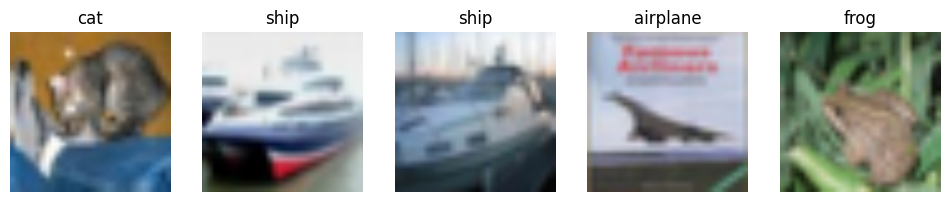

In [11]:
show_samples(test_data)

In [12]:
import timm

teacher_model = timm.create_model("efficientnet_b0",pretrained=True,num_classes =10)
teacher_model.to(device=device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(teacher_model.parameters(),lr=1e-4)

In [14]:
def train_model(model,loader,criterion,optimiser,epochs=3):
  model.train()
  for epoch in range(epochs):
    total_loss,total_correct = 0,0
    for images,labels in loader:
      images,labels = images.to(device),labels.to(device)
      y_preds = model(images)
      loss = criterion(y_preds,labels)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      total_loss += loss.item()*(images.size(0))
      total_correct = (y_preds.argmax(1)==labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    acc = total_correct / len(loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Acc: {acc*100:.2f}%")


In [15]:
train_model(teacher_model,labeled_data_loader,criterion,optimiser,epochs=3)

Epoch [1/3] | Loss: 1.4971 | Acc: 0.12%
Epoch [2/3] | Loss: 0.2827 | Acc: 0.10%
Epoch [3/3] | Loss: 0.0961 | Acc: 0.14%


In [16]:
torch.save(teacher_model.state_dict(),"teacher_efficientnet_b0.pth")
print("teacher model saved")

teacher model saved


In [17]:
from torch.nn import functional as F

teacher_model.load_state_dict(torch.load("teacher_efficientnet_b0.pth",map_location=device))
teacher_model.eval()

pseudo_images,pseudo_labels = [] , []
min_confs=0.9

with torch.no_grad():
  for images,_ in unlabeled_data_loader:
    images = images.to(device)
    outputs = teacher_model(images)
    probs = F.softmax(outputs)
    confs,preds = probs.max(dim=1)

    mask = confs >= min_confs
    selected_images = images[mask]
    selected_labels = preds[mask]

    pseudo_images.extend(selected_images.cpu())
    pseudo_labels.extend(selected_labels.cpu())

print(f"✅ Pseudo-labels created: {len(pseudo_labels)} samples above {min_confs*100:.0f}% confidence")

/tmp/ipython-input-3054173857.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs)


✅ Pseudo-labels created: 3375 samples above 90% confidence


In [18]:
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
from torchvision.transforms import ToPILImage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


student_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
to_pil = ToPILImage()


processed_images = []
for img in pseudo_images:
    if isinstance(img, torch.Tensor):
        img = to_pil(img.cpu())
    processed_images.append(student_transform(img))

pseudo_images_tensor = torch.stack(processed_images)
pseudo_labels_tensor = torch.tensor(pseudo_labels, dtype=torch.long)

pseudo_data = TensorDataset(pseudo_images_tensor, pseudo_labels_tensor)

student_data_loader = DataLoader(pseudo_data, batch_size=64, shuffle=True)
print(f"✅ Student dataset created: {len(student_data_loader)} samples total")


student_model = timm.create_model("efficientnet_b0",
                                  pretrained=True,
                                  num_classes=10,
                                  drop_rate=0.3)
student_model = student_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)


def train_student(model, loader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss, total_correct = 0, 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / len(loader.dataset)
        print(f"[Student] Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Acc: {acc*100:.2f}%")


train_student(student_model, student_data_loader, criterion, optimizer, epochs=3)
torch.save(student_model.state_dict(), "student_efficientnet_b0.pth")
print("✅ Student model trained and saved successfully.")


Device: cuda
✅ Student dataset created: 53 samples total
[Student] Epoch [1/3] | Loss: 2.6208 | Acc: 36.80%
[Student] Epoch [2/3] | Loss: 0.7863 | Acc: 73.72%
[Student] Epoch [3/3] | Loss: 0.3543 | Acc: 87.44%
✅ Student model trained and saved successfully.


In [20]:
train_student(student_model, labeled_data_loader, criterion, optimizer, epochs=3)
torch.save(student_model.state_dict(), "student_efficientnet_b0.pth")
print("✅ Student model trained and saved successfully.")

[Student] Epoch [1/3] | Loss: 0.9834 | Acc: 71.48%
[Student] Epoch [2/3] | Loss: 0.3407 | Acc: 88.22%
[Student] Epoch [3/3] | Loss: 0.1704 | Acc: 94.32%
✅ Student model trained and saved successfully.


✅ Teacher Accuracy: 81.12%
✅ Student Accuracy: 86.03%


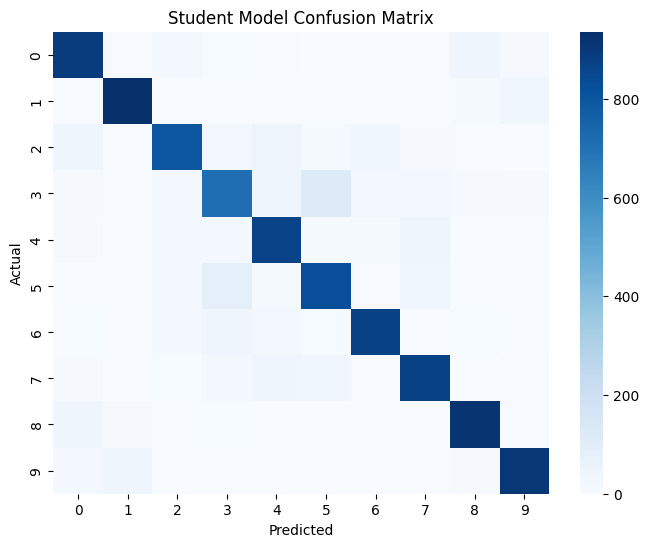

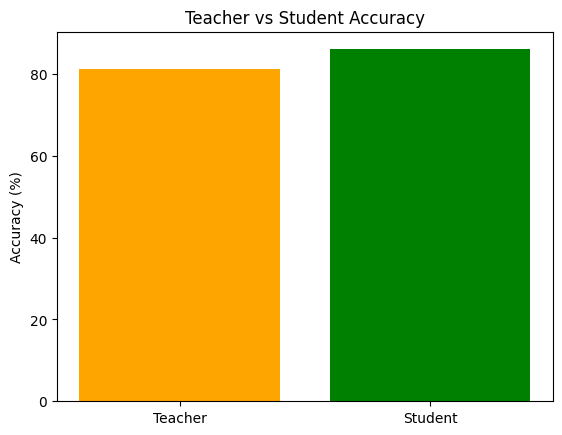

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def evaluate(model, dataloader, name="Model"):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images, lbls = images.to(device), lbls.to(device)
            outputs = model(images)
            preds.extend(outputs.argmax(1).cpu().numpy())
            labels.extend(lbls.cpu().numpy())
    acc = accuracy_score(labels, preds)
    print(f"✅ {name} Accuracy: {acc*100:.2f}%")
    return acc, labels, preds

teacher_model.load_state_dict(torch.load("teacher_efficientnet_b0.pth", map_location=device))
student_model.load_state_dict(torch.load("student_efficientnet_b0.pth", map_location=device))

teacher_acc, teacher_labels, teacher_preds = evaluate(teacher_model, test_data_loader, "Teacher")
student_acc, student_labels, student_preds = evaluate(student_model, test_data_loader, "Student")

cm = confusion_matrix(student_labels, student_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Student Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 📈 Comparison bar chart
plt.bar(["Teacher", "Student"], [teacher_acc*100, student_acc*100], color=["orange","green"])
plt.title("Teacher vs Student Accuracy")
plt.ylabel("Accuracy (%)")
plt.show()
